In [1]:
import glob
import cv2
import os
images_t = glob.glob("RiceLeafDisease/bb150/JPEGImages/*.jpg")
images_t.sort()
masks_t = glob.glob("RiceLeafDisease/bb150/SegmentationClass2/*.png")
masks_t.sort()
print(len(images_t))
print(len(masks_t))

150
150


In [2]:
import os
import matplotlib.pyplot as plt
image_t=[]
mask_t=[]
for x in images_t:
  im=cv2.imread(str(x),cv2.IMREAD_COLOR)
  im=cv2.resize(im,(256,256))
  image_t.append(im)

In [3]:
for y in masks_t:
  ma=cv2.imread(str(y),cv2.IMREAD_GRAYSCALE)
  ma=cv2.resize(ma,(256,256),interpolation = cv2.INTER_NEAREST)
  mask_t.append(ma)

In [4]:
import numpy as np
img_array_t=np.array(image_t)
mask_array_t=np.array(mask_t)
mask_array_t=np.expand_dims(mask_array_t,axis=-1)
mask_array_t=mask_array_t.astype(np.float32)
print(img_array_t.shape)
print(mask_array_t.shape)

(150, 256, 256, 3)
(150, 256, 256, 1)


In [5]:
s=np.unique(mask_array_t)
s

array([0., 1., 2.], dtype=float32)

In [6]:
for i in s[1:]:
    a=np.where(mask_array_t==i)
    mask_array_t[a]=1

In [7]:
print(np.unique(mask_array_t))

[0. 1.]


In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(img_array_t,mask_array_t,test_size=0.2,random_state=10)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import os

input_shape = (256, 256, 3)

base_model = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')

# Remove the top layers (classification head) of the pre-trained model
base_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)

# Encoder part
inputs = base_model.input
encoder_output = base_model.output

# Decoder part
up0 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D()(encoder_output))
merge0 = concatenate([base_model.get_layer('block4_conv3').output, up0], axis=-1)
conv0 = Conv2D(512, 3, activation='relu', padding='same')(merge0)
conv0 = Conv2D(512, 3, activation='relu', padding='same')(conv0)

up1 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D()(conv0))
merge1 = concatenate([base_model.get_layer('block3_conv3').output, up1], axis=-1)
conv1 = Conv2D(256, 3, activation='relu', padding='same')(merge1)
conv1 = Conv2D(256, 3, activation='relu', padding='same')(conv1)

up2 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D()(conv1))
merge2 = concatenate([base_model.get_layer('block2_conv2').output, up2], axis=-1)
conv2 = Conv2D(128, 3, activation='relu', padding='same')(merge2)
conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)

up3 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D()(conv2))
merge3 = concatenate([base_model.get_layer('block1_conv2').output, up3], axis=-1)
conv3 = Conv2D(64, 3, activation='relu', padding='same')(merge3)
conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)

# Output layer
outputs = Conv2D(1, 1, activation='sigmoid')(conv3)

model = Model(inputs=inputs, outputs=outputs)


In [10]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 25,854,657 (98.63 MB)

 Trainable params: 25,854,657 (98.63 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assuming img_array_t and mask_array_t are your training data
history = model.fit(X_train, 
                    Y_train,
                    batch_size=1,
                    epochs=10,
                    steps_per_epoch=10)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5112 - loss: 271.8336
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.5742 - loss: 34.9872
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8801 - loss: 2.2426
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9671 - loss: 0.4703
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9125 - loss: 2.5988
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.7757 - loss: 3.2890
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8123 - loss: 1.7757
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8252 - loss: 9.4128
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.7764 - loss: 3.6171
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.9328 - loss: 3.2458


In [12]:
predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


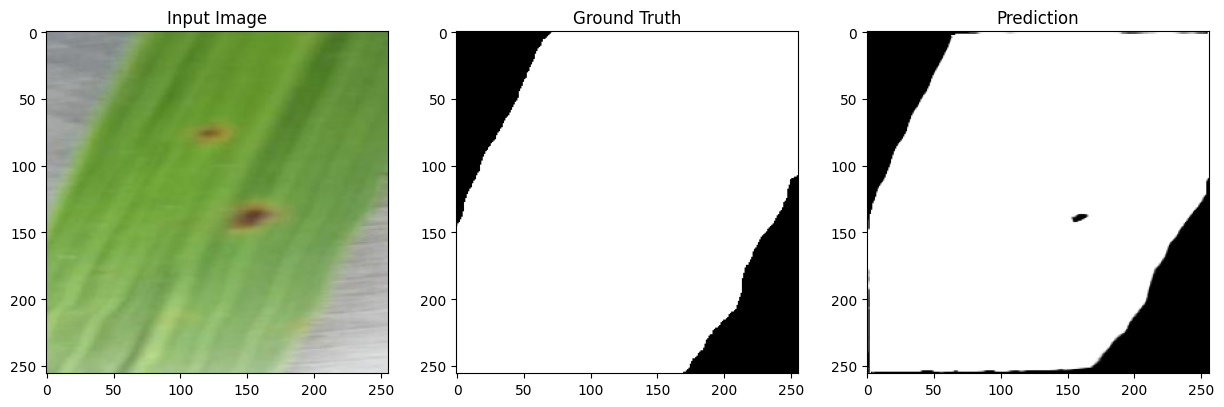

In [13]:
index = 20  # change index to visualize different samples

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(X_test[index], cv2.COLOR_BGR2RGB))
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(Y_test[index].squeeze(), cmap='gray')
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(predictions[index].squeeze(), cmap='gray')
plt.title('Prediction')

plt.show()

In [14]:
model.evaluate(X_test,Y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.8723 - loss: 6.4216


[6.421575546264648, 0.8722625970840454]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


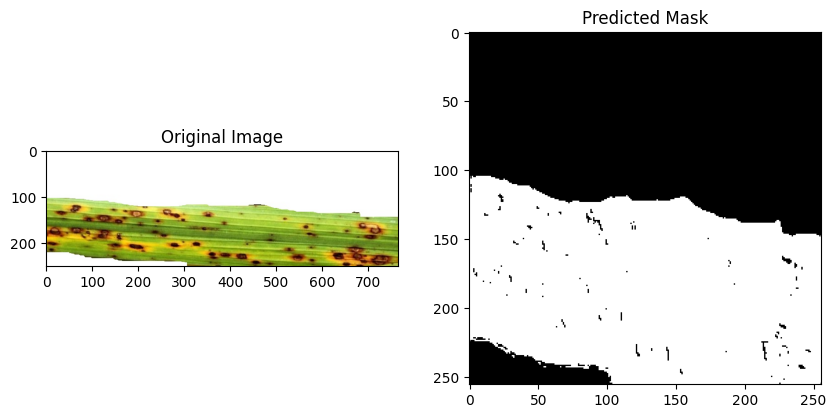

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Function to preprocess the image
def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

# Function to postprocess the predicted mask
def postprocess_mask(mask):
    mask = mask.squeeze()
    mask = (mask > 0.5).astype(np.uint8)*255
    return mask

# Load custom image and preprocess it
custom_image_path = "rice_leaf_diseases//Brown spot//DSC_0100.jpg"
custom_image = preprocess_image(custom_image_path)
custom_image = np.expand_dims(custom_image, axis=0)  # Add batch dimension

# Predict the mask for the custom image
predicted_mask = model.predict(custom_image)

# Postprocess the predicted mask
predicted_mask = postprocess_mask(predicted_mask)

# Visualize the original image and the predicted mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(custom_image_path), cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask,cmap='gray')
plt.title('Predicted Mask')

plt.show()
